In [1]:
from metaspace import SMInstance
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from deepims_clust import DeepClustering
from deepims_clust.utils import size_adaption, size_adaption_symmetric

import umap
%load_ext autoreload
%autoreload 2

/home/trose/.conda/envs/torch-gpuCUDA12/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Datasets

In [2]:
evaluation_datasets = [
    '2022-12-07_02h13m50s',
    '2022-12-07_02h13m20s',
    '2022-12-07_02h10m45s',
    '2022-12-07_02h09m41s',
    '2022-12-07_02h08m52s',
    '2022-12-07_01h02m53s',
    '2022-12-07_01h01m06s'
                  ]

In [3]:
training_results = {}
training_images = {}
training_if = {}
polarity = '+'

sm = SMInstance()

for k in evaluation_datasets:
    ds = sm.dataset(id=k)
    results = ds.results(database=("HMDB", "v4"), fdr=0.2).reset_index()
    training_results[k] = results
    tmp = ds.all_annotation_images(fdr=0.2, database=("HMDB", "v4"), only_first_isotope=True)
    onsample = dict(zip(results['formula'].str.cat(results['adduct']), ~results['offSample']))
    formula = [x.formula+x.adduct for x in tmp if onsample[x.formula+x.adduct]]
    tmp = np.array([x._images[0] for x in tmp if onsample[x.formula+x.adduct]])
    training_images[k] = tmp
    training_if[k] = formula

100%|████████████████████████████████████████| 241/241 [00:01<00:00, 232.78it/s]


## Size adaption


In [4]:
[x.shape for x in training_images.values()]

[(245, 74, 84),
 (221, 88, 88),
 (194, 41, 78),
 (237, 56, 85),
 (276, 71, 82),
 (201, 35, 55),
 (186, 60, 44)]

In [5]:
padding_images = size_adaption_symmetric(training_images)
[x.shape for x in padding_images.values()]

[(245, 88, 88),
 (221, 88, 88),
 (194, 88, 88),
 (237, 88, 88),
 (276, 88, 88),
 (201, 88, 88),
 (186, 88, 88)]

## Ion overlap

In [6]:
tst = set(training_if['2022-12-07_02h13m50s']).intersection(set(training_if['2022-12-07_02h13m20s']), 
                                                          set(training_if['2022-12-07_02h10m45s']), 
                                                          set(training_if['2022-12-07_02h09m41s']), 
                                                          set(training_if['2022-12-07_02h08m52s']), 
                                                          set(training_if['2022-12-07_01h02m53s']), 
                                                          set(training_if['2022-12-07_01h01m06s']))

In [7]:
print(f'Intersection of all datasets: {len(tst)}')

Intersection of all datasets: 126


## Preparing data for training

In [8]:
training_dsid = [
    '2022-12-07_01h01m06s',
    '2022-12-07_02h13m20s',
    '2022-12-07_02h10m45s',
    '2022-12-07_02h09m41s',
    '2022-12-07_02h08m52s',
    '2022-12-07_01h02m53s'
                  ]

testing_dsid = [
    '2022-12-07_02h13m50s'
]

In [9]:
training_data = []
training_datasets = [] 
training_ions = []

testing_data = []
testing_datasets = [] 
testing_ions = []


for dsid, imgs in padding_images.items():
    
    if dsid in training_dsid:
        training_data.append(imgs)
        training_datasets += [dsid] * imgs.shape[0]
        training_ions += training_if[dsid]
    
    testing_data.append(imgs)
    testing_datasets += [dsid] * imgs.shape[0]
    testing_ions += training_if[dsid]
        
    
training_data = np.concatenate(training_data)
training_datasets = np.array(training_datasets)
training_ions = np.array(training_ions)

testing_data = np.concatenate(testing_data)
testing_datasets = np.array(testing_datasets)
testing_ions = np.array(testing_ions)

# Building full torch model

## Training model

In [18]:
model = DeepClustering(
                images=training_data,
                dataset_labels=training_datasets,
                ion_labels=training_ions,
                num_cluster=8,
                initial_upper=93,
                initial_lower=37,
                upper_iteration=1.5,
                lower_iteration=1.5,
                dataset_specific_percentiles=True,
                random_flip=True,
                knn=False, k=5,
                lr=0.0001, batch_size=128,
                pretraining_epochs=1,
                training_epochs=16,
                cae_encoder_dim=20,
                use_gpu=True,
                random_seed=1225
            )

After 16 epochs, the upper bound will be: 69.0.
After 16 epochs, the lower bound will be: 61.0.


In [19]:
model.train()

CAE Final conv size = 3136
CNNClust final conv dim = 289
Pretraining Epoch: 00 Training Loss: 0.323779 | Validation Loss: 0.025374
new test2
tensor([0., 0., 0., 0., 0., 0.], device='cuda:0')
worked2


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [39]:
import torch

tns = torch.arange(100).reshape((10, -1))
idx = torch.tensor([True, False, False, True, False, True, True, False, False, False])

tns[idx, :][:, idx] = 10000

In [40]:
tns

tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9],
        [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
        [20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
        [30, 31, 32, 33, 34, 35, 36, 37, 38, 39],
        [40, 41, 42, 43, 44, 45, 46, 47, 48, 49],
        [50, 51, 52, 53, 54, 55, 56, 57, 58, 59],
        [60, 61, 62, 63, 64, 65, 66, 67, 68, 69],
        [70, 71, 72, 73, 74, 75, 76, 77, 78, 79],
        [80, 81, 82, 83, 84, 85, 86, 87, 88, 89],
        [90, 91, 92, 93, 94, 95, 96, 97, 98, 99]])

In [17]:
torch.zeros(6)

tensor([0., 0., 0., 0., 0., 0.])

In [42]:
import torch.nn as nn
e = nn.Embedding(5, 1).detach()
e = e.to('cuda')

AttributeError: 'Embedding' object has no attribute 'detach'

In [46]:
torch.unique(b[2]).size(0)

6

In [41]:
for x in torch.unique(b[2].detach().to('cuda')):
    print(e(x))

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


## Evaluation

/home/trose/.conda/envs/torch-gpuCUDA12/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/trose/.conda/envs/torch-gpuCUDA12/lib/python3.10/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


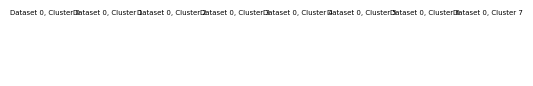

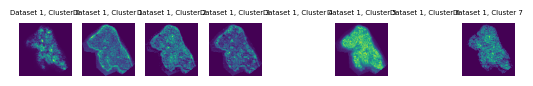

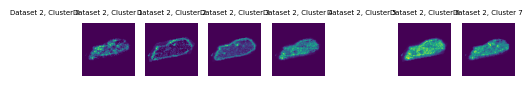

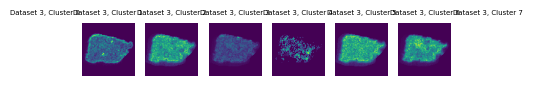

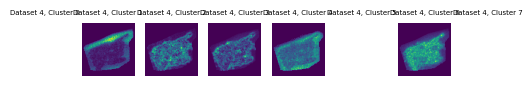

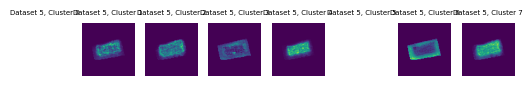

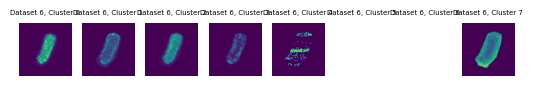

In [15]:
pred_labels = model.inference()

# Loop over datasets:
ds_counter = 0
for ds in evaluation_datasets:
    ds_imgs = model.image_data[model.dataset_labels==ds]
    curr_labels = pred_labels[model.dataset_labels==ds]

    cluster_ion_images = []
    for cluster in set(pred_labels):
        cluster_ion_images.append(np.mean(ds_imgs[curr_labels==cluster], axis=0))
    fig, axs = plt.subplots(ncols=len(set(pred_labels)))
    counter = 0
    for ax, im in zip(axs, cluster_ion_images):
        ax.imshow(im)
        ax.axis('off')
        ax.set_title(f'Dataset {ds_counter}, Cluster {counter}', fontdict={'fontsize': 5})
        counter += 1
    plt.show()
    ds_counter += 1

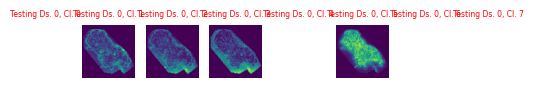

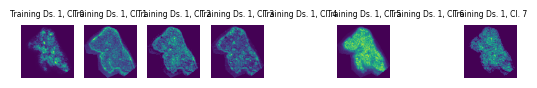

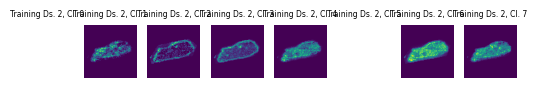

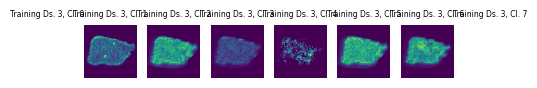

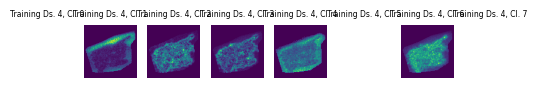

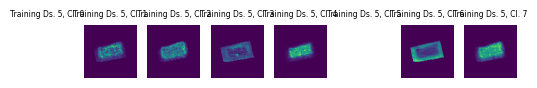

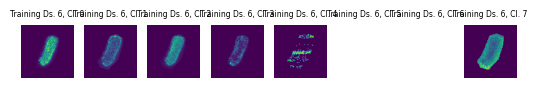

In [16]:
pred_labels = model.inference(new_data=testing_data)

image_dat = model.image_normalization(new_data=testing_data)

# Loop over datasets:
ds_counter = 0
for ds in evaluation_datasets:
    
        ds_imgs = image_dat[testing_datasets==ds]
        curr_labels = pred_labels[testing_datasets==ds]

        cluster_ion_images = []
        for cluster in set(pred_labels):
            cluster_ion_images.append(np.mean(ds_imgs[curr_labels==cluster], axis=0))
        fig, axs = plt.subplots(ncols=len(set(pred_labels)))
        counter = 0
        for ax, im in zip(axs, cluster_ion_images):
            ax.imshow(im)
            ax.axis('off')
            if ds in testing_dsid:
                ax.set_title(f'Testing Ds. {ds_counter}, Cl. {counter}', fontdict={'fontsize': 5.5}, color= 'red')
            else:
                ax.set_title(f'Training Ds. {ds_counter}, Cl. {counter}', fontdict={'fontsize': 5.5})
            counter += 1
        plt.show()
        ds_counter += 1

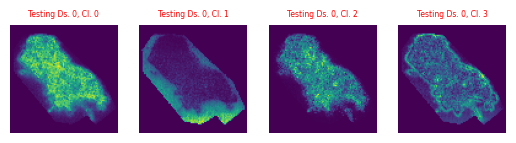

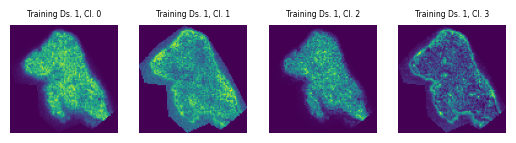

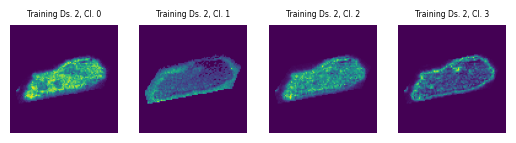

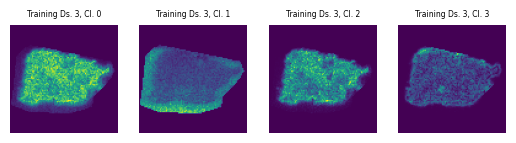

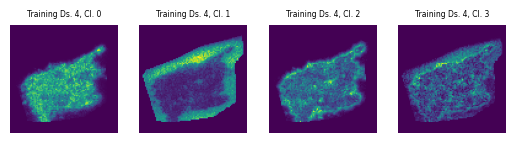

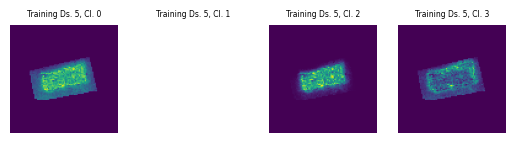

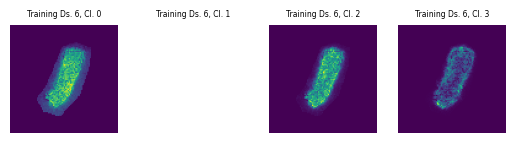

In [14]:
pred_labels = model.inference(cae, clust, new_data=testing_data)

image_dat = model.image_normalization(new_data=testing_data)

# Loop over datasets:
ds_counter = 0
for ds in evaluation_datasets:
    
        ds_imgs = image_dat[testing_datasets==ds]
        curr_labels = pred_labels[testing_datasets==ds]

        cluster_ion_images = []
        for cluster in set(pred_labels):
            cluster_ion_images.append(np.mean(ds_imgs[curr_labels==cluster], axis=0))
        fig, axs = plt.subplots(ncols=len(set(pred_labels)))
        counter = 0
        for ax, im in zip(axs, cluster_ion_images):
            ax.imshow(im)
            ax.axis('off')
            if ds in testing_dsid:
                ax.set_title(f'Testing Ds. {ds_counter}, Cl. {counter}', fontdict={'fontsize': 5.5}, color= 'red')
            else:
                ax.set_title(f'Training Ds. {ds_counter}, Cl. {counter}', fontdict={'fontsize': 5.5})
            counter += 1
        plt.show()
        ds_counter += 1